In [25]:
import random
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras import callbacks

In [26]:
BATCH_SIZE = 64
IMG_SIZE = (200, 200)  

train_file='/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train'
train_ds,val_ds = tf.keras.utils.image_dataset_from_directory(
    train_file,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    seed=42,
    subset='both',
    shuffle=True
)
class_names = train_ds.class_names

Found 87000 files belonging to 29 classes.
Using 69600 files for training.
Using 17400 files for validation.


In [27]:
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

In [28]:
base_model = EfficientNetB1(
    weights='imagenet',
    input_shape=(200, 200, 3),
    include_top=False
)


data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.05),           
    tf.keras.layers.RandomZoom(0.05),               
    tf.keras.layers.RandomContrast(0.05),           
    tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1,fill_mode='nearest'),
    # layers.RandomFlip("horizontal"),    # Avoid flipping (ASL signs are not symmetric!)
])

inputs = tf.keras.layers.Input(shape=(200, 200, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.efficientnet.preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name='pooling')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(29 , activation='softmax')(x)

final_model = tf.keras.models.Model(inputs, outputs)

final_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 200, 200, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 200, 200, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb1 (Functional)          │ (None, 7, 7, 1280)          │       6,575,239 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pooling (GlobalAveragePooling2D)     │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 29)                  │           3,741 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,742,948 (25.72 MB)

 Trainable params: 6,680,893 (25.49 MB)

 Non-trainable params: 62,055 (242.41 KB)

In [29]:
# Define callbacks
callbacks = [
    callbacks.EarlyStopping(
        monitor='val_accuracy', 
        patience=6,             
        restore_best_weights=True,  
        verbose=1
    ),
    
    # Learning Rate Reduction
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',      
        factor=0.5,              
        patience=3,              
        min_lr=1e-7,             
        verbose=1
    ),
]

In [30]:
# 1. Keep base model frozen
base_model.trainable = False

# 2. Compile with higher initial LR
final_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 3. First training phase
history_frozen = final_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks,  # Use the callbacks you defined earlier
    verbose=1
)

Epoch 1/10


E0000 00:00:1750174356.896264      35 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_3_1/efficientnetb1_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1088/1088 ━━━━━━━━━━━━━━━━━━━━ 164s 130ms/step - accuracy: 0.6185 - loss: 1.4065 - val_accuracy: 0.9240 - val_loss: 0.2471 - learning_rate: 0.0010
Epoch 2/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 135s 124ms/step - accuracy: 0.8958 - loss: 0.3435 - val_accuracy: 0.9473 - val_loss: 0.1616 - learning_rate: 0.0010
Epoch 3/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 135s 124ms/step - accuracy: 0.9178 - loss: 0.2530 - val_accuracy: 0.9445 - val_loss: 0.1652 - learning_rate: 0.0010
Epoch 4/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 135s 124ms/step - accuracy: 0.9289 - loss: 0.2167 - val_accuracy: 0.9581 - val_loss: 0.1241 - learning_rate: 0.0010
Epoch 5/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 135s 124ms/step - accuracy: 0.9377 - loss: 0.1901 - val_accuracy: 0.9623 - val_loss: 0.1119 - learning_rate: 0.0010
Epoch 6/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 135s 124ms/step - accuracy: 0.9420 - loss: 0.1718 - val_accuracy: 0.9655 - val_loss: 0.1012 - learning_rate: 0.0010
Epoch 7/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 134s 124ms/step - acc

In [31]:
# 1. unfreez the First 100 layer
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False  

# 2. Recompile with lower LR
final_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 3. Fine-tune callbacks (more aggressive)
fine_tune_callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=5,  # Shorter patience for fine-tuning
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,  # More gentle LR reduction
        patience=2,
        min_lr=1e-7
    )
]

# 4. Second training phase
history_fine_tune = final_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=16,  
    initial_epoch=history_frozen.epoch[-1] + 1,  
    callbacks=fine_tune_callbacks,
    verbose=1
)

Epoch 11/16


E0000 00:00:1750175829.466980      35 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_3_1/efficientnetb1_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1088/1088 ━━━━━━━━━━━━━━━━━━━━ 377s 284ms/step - accuracy: 0.9212 - loss: 0.2719 - val_accuracy: 0.9955 - val_loss: 0.0174 - learning_rate: 1.0000e-04
Epoch 12/16
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 302s 278ms/step - accuracy: 0.9966 - loss: 0.0101 - val_accuracy: 0.9988 - val_loss: 0.0035 - learning_rate: 1.0000e-04
Epoch 13/16
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 302s 278ms/step - accuracy: 0.9979 - loss: 0.0069 - val_accuracy: 0.9990 - val_loss: 0.0032 - learning_rate: 1.0000e-04
Epoch 14/16
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 302s 277ms/step - accuracy: 0.9982 - loss: 0.0055 - val_accuracy: 0.9995 - val_loss: 0.0016 - learning_rate: 1.0000e-04
Epoch 15/16
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 301s 276ms/step - accuracy: 0.9984 - loss: 0.0052 - val_accuracy: 0.9999 - val_loss: 2.4393e-04 - learning_rate: 1.0000e-04
Epoch 16/16
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 301s 277ms/step - accuracy: 0.9986 - loss: 0.0047 - val_accuracy: 0.9999 - val_loss: 1.5430e-04 - learning_rate: 1.0000e-04


In [32]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_true = []
y_pred_probs = []

for images, labels in val_ds:
    y_true.extend(labels.numpy())
    y_pred_probs.extend(final_model.predict(images, verbose=0))

y_true = np.array(y_true)
y_pred_probs = np.array(y_pred_probs)

# Check if labels are one-hot encoded
if len(y_true.shape) > 1 and y_true.shape[1] > 1:
    y_true = np.argmax(y_true, axis=1)

y_pred = np.argmax(y_pred_probs, axis=1)

report = classification_report(
    y_true,
    y_pred,
    digits=4
)

print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       623
           1     1.0000    1.0000    1.0000       634
           2     1.0000    1.0000    1.0000       601
           3     1.0000    1.0000    1.0000       643
           4     1.0000    1.0000    1.0000       548
           5     1.0000    1.0000    1.0000       646
           6     1.0000    1.0000    1.0000       612
           7     1.0000    1.0000    1.0000       626
           8     1.0000    1.0000    1.0000       607
           9     1.0000    1.0000    1.0000       626
          10     1.0000    1.0000    1.0000       553
          11     1.0000    0.9983    0.9992       593
          12     1.0000    1.0000    1.0000       594
          13     1.0000    1.0000    1.0000       555
          14     1.0000    1.0000    1.0000       595
          15     1.0000    1.0000    1.0000       606
          16     1.0000    1.0000    1.0000       636
    

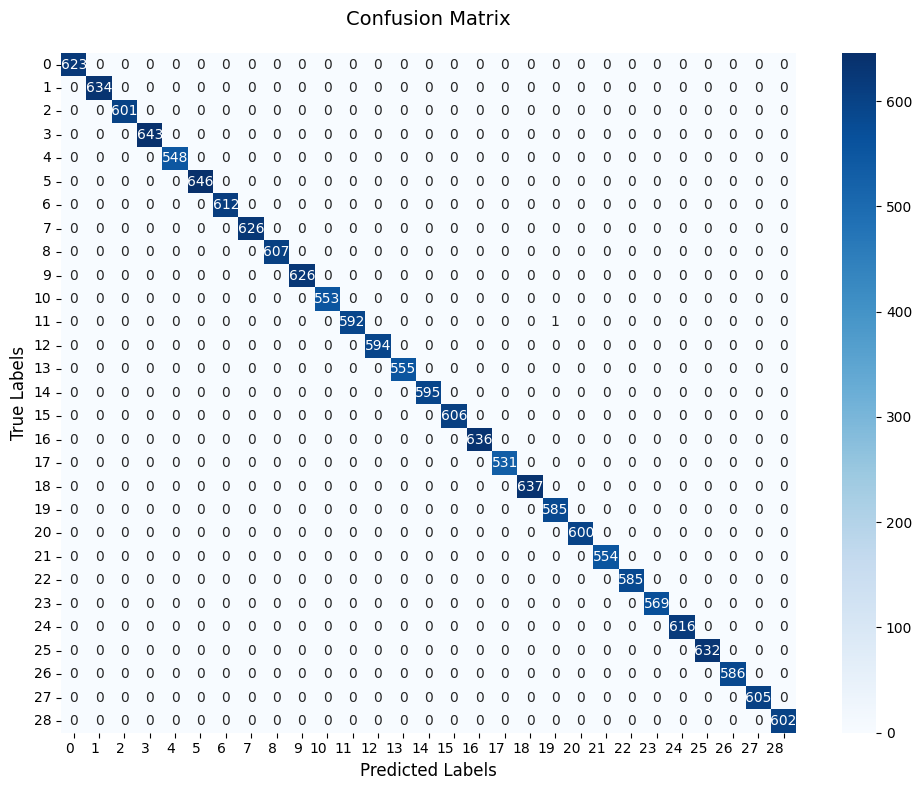

In [33]:
def plot_confusion_matrix(y_true, y_pred):
    """
    Plots a beautiful confusion matrix with annotations
    
    Args:
        y_true: Array of true labels
        y_pred: Array of predicted labels
        class_names: List of class names
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Create figure
    plt.figure(figsize=(10, 8))
    
    # Create heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',)
    
    # Add labels and title
    plt.xlabel('Predicted Labels', fontsize=12)
    plt.ylabel('True Labels', fontsize=12)
    plt.title('Confusion Matrix', fontsize=14, pad=20)
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=0, ha='right')
    plt.yticks(rotation=0)
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

# Usage with your TensorFlow dataset
# 1. Get predictions and true labels
y_true = []
y_pred = []

for images, labels in val_ds:
    # Get true labels (convert from one-hot if needed)
    if len(labels.shape) > 1:  # If one-hot encoded
        y_true.extend(np.argmax(labels.numpy(), axis=1))
    else:
        y_true.extend(labels.numpy())
    
    # Get predictions
    preds = final_model.predict(images, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1))


plot_confusion_matrix(y_true, y_pred, )

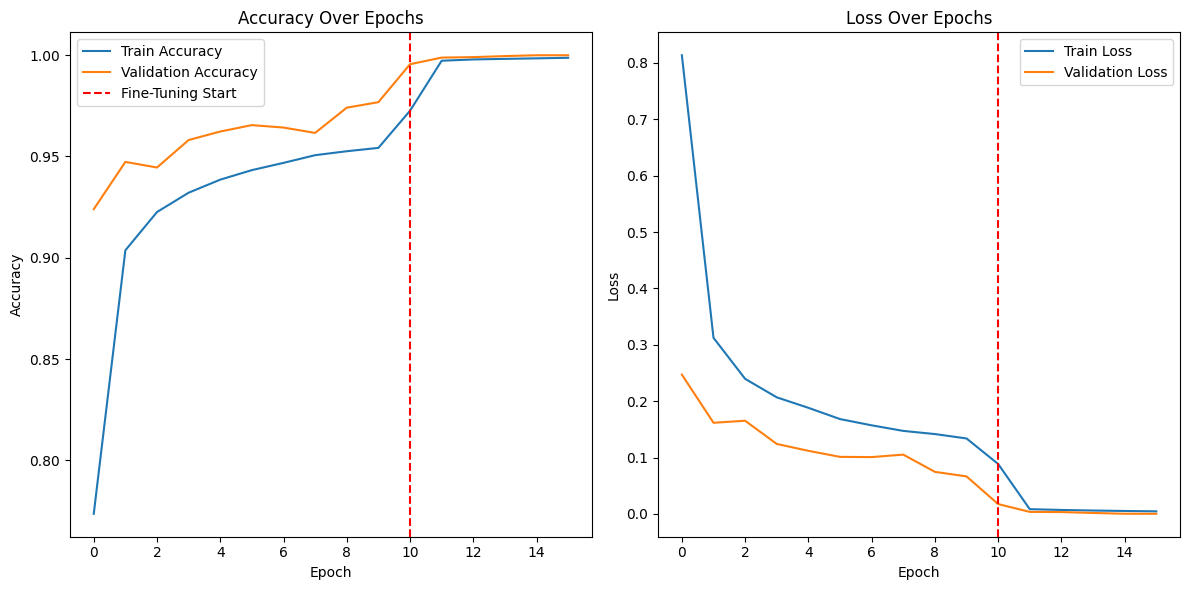

In [34]:
def plot_training_history(history_frozen, history_fine_tune=None):
    plt.figure(figsize=(12, 6))
    
    # Combine histories if fine-tuning was done
    if history_fine_tune:
        for key in history_frozen.history:
            history_frozen.history[key] += history_fine_tune.history[key]
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history_frozen.history['accuracy'], label='Train Accuracy')
    plt.plot(history_frozen.history['val_accuracy'], label='Validation Accuracy')
    if history_fine_tune:
        plt.axvline(len(history_frozen.history['accuracy']) - len(history_fine_tune.history['accuracy']), 
                   color='red', linestyle='--', label='Fine-Tuning Start')
    plt.title('Accuracy Over Epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    
    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history_frozen.history['loss'], label='Train Loss')
    plt.plot(history_frozen.history['val_loss'], label='Validation Loss')
    if history_fine_tune:
        plt.axvline(len(history_frozen.history['loss']) - len(history_fine_tune.history['loss']), 
                   color='red', linestyle='--')
    plt.title('Loss Over Epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Plot both phases
plot_training_history(history_frozen, history_fine_tune)

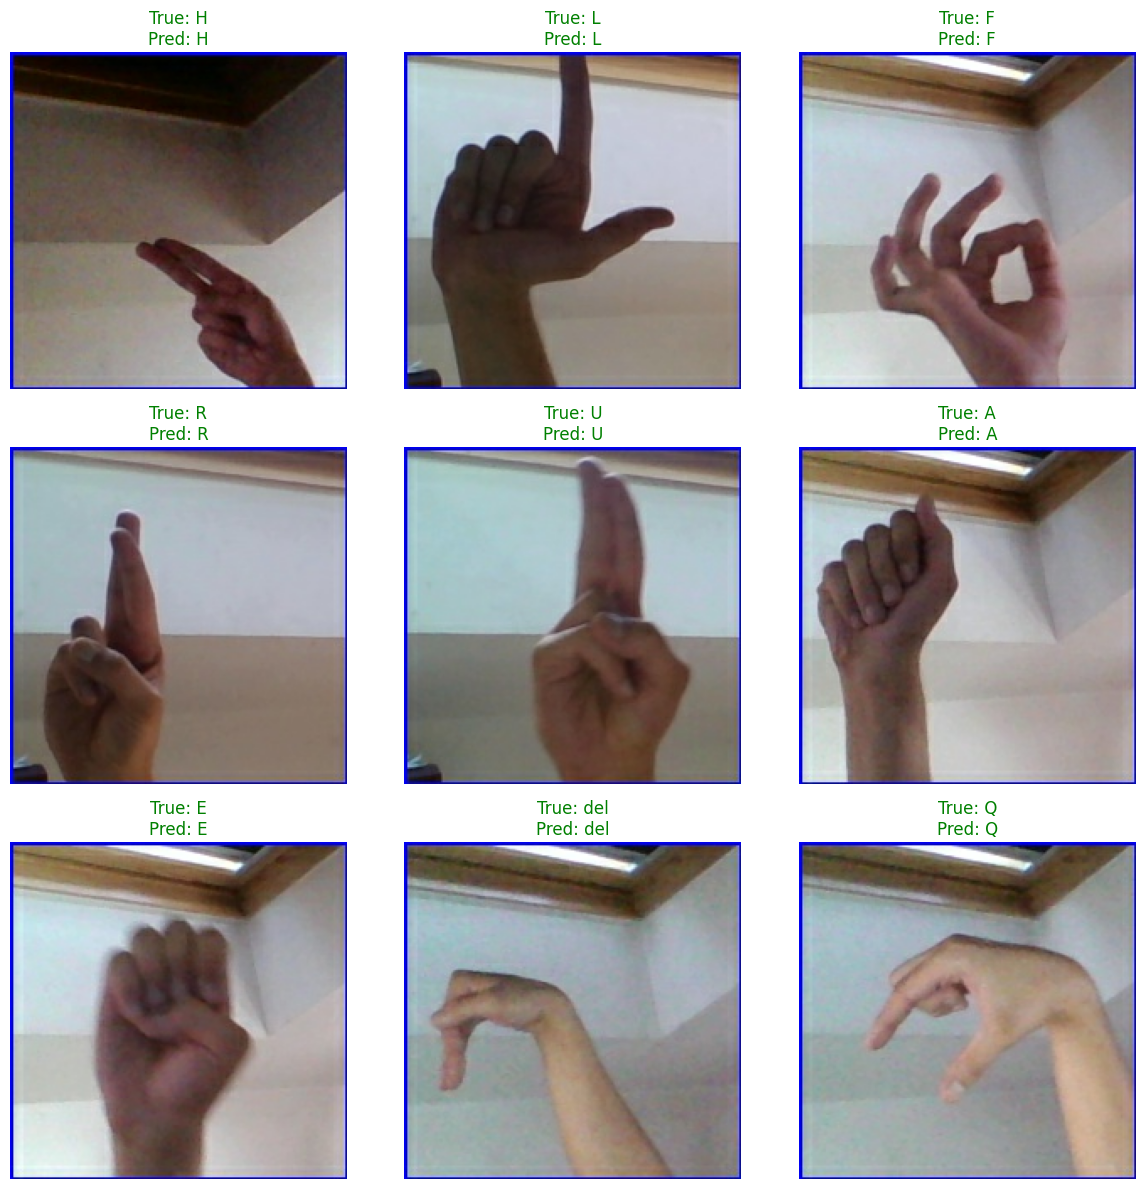

In [35]:
def plot_random_predictions(model, dataset, class_names, num_images=9):
    """
    Plots randomly selected images with their true and predicted labels.
    
    Args:
        model: Trained Keras model
        dataset: TensorFlow dataset (batched)
        class_names: List of class names
        num_images: Number of images to display (default 9)
    """
    # Collect all images and labels into a list (can handle small/medium datasets)
    all_images = []
    all_labels = []
    for images, labels in dataset:
        all_images.extend(images.numpy())
        all_labels.extend(labels.numpy())

    # Randomly select images
    indices = random.sample(range(len(all_images)), num_images)
    selected_images = [all_images[i] for i in indices]
    selected_labels = [all_labels[i] for i in indices]

    # Prepare batch for prediction
    selected_images_array = np.array(selected_images)
    preds = model.predict(selected_images_array, verbose=0)
    pred_classes = np.argmax(preds, axis=1)

    # Handle one-hot encoded labels
    if len(np.array(selected_labels).shape) > 1:
        true_classes = np.argmax(selected_labels, axis=1)
    else:
        true_classes = selected_labels

    # Plot
    plt.figure(figsize=(12, 12))
    for i in range(num_images):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(selected_images[i].astype("uint8"))

        true_label = class_names[true_classes[i]]
        pred_label = class_names[pred_classes[i]]
        color = 'green' if true_label == pred_label else 'red'

        plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()


# Usage
plot_random_predictions(final_model, val_ds, class_names)